# Hierarchical optimization

In this notebook we illustrate how to do hierarchical optimization in pyPESTO.

A frequent problem occuring in parameter estimation for dynamical systems is that the objective function takes a form

$$ J(\theta, s, b, \sigma^2) = \sum_i \left[\log(2\pi\sigma_i^2) + \frac{(\bar y_i - (s_iy_i(\theta) + b_i))^2}{\sigma_i^2}\right] $$

with data $\bar y_i$, parameters $\eta = (\theta,s,b,\sigma^2)$, and ODE simulations $y(\theta)$. Here, we consider a Gaussian noise model, but also others (e.g. Laplace) are possible. Here we want to leverage that the parameter vector $\eta$ can be split into "dynamic" parameters $\theta$ that are required for simulating the ODE, and "static" parameters $s,b,\sigma^2$ that are only required to scale the simulations and formulate the objective function. As simulating the ODE usually dominates the computational complexity, one can exploit this separation of parameters by formulating an outer optimization problem in which $\theta$ is optimized, and an inner optimization problem in which $s,b,\sigma^2$ are optimized conditioned on $\theta$. This approach has shown to have superior performance to the classic approach of jointly optimizing $\eta$. 

In pyPESTO, we have implemented the algorithms developed in [Loos et al.; Hierarchical optimization for the efficient parametrization of ODE models; Bioinformatics 2018](https://academic.oup.com/bioinformatics/article/34/24/4266/5053308) (covering Gaussian and Laplace noise models with gradients computed via forward sensitivity analysis) and [Schmiester et al.; Efficient parameterization of large-scale dynamic models based on relative measurements; Bioinformatics 2019](https://academic.oup.com/bioinformatics/article/36/2/594/5538985) (extending to offset parameters and adjoint sensitivity analysis).

However, the current implementation only supports:
- Gaussian (normal) noise distributions
- unbounded inner parameters $\eta$
- linearly-scaled inner parameters $\eta$

In the following we will demonstrate how to use hierarchical optimization, and we will compare optimization results for the following scenarios:

* Standard non-hierarchical gradient-based optimization with adjoint sensitivity analysis
* Hierarchical gradient-based optimization with analytical inner solver and adjoint sensitivity analysis
* Hierarchical gradient-based optimization with analytical inner solver and forward sensitivity analysis
* Hierarchical gradient-based optimization with numerical inner solver and adjoint sensitivity analysis

In [1]:
import os
import time

import amici
import fides
import matplotlib.pyplot as plt
import numpy as np
import petab
from matplotlib.colors import to_rgba

import pypesto
from pypesto.hierarchical.solver import (
    AnalyticalInnerSolver,
    NumericalInnerSolver,
)
from pypesto.optimize.options import OptimizeOptions
from pypesto.petab import PetabImporter

## Problem specification

We consider a version of the [Boehm et al.; Journal of Proeome Research 2014] model, modified to include scalings $s$, offsets $b$, and noise parameters $\sigma^2$.

NB: We load two PEtab problems here, because the employed standard and hierarchical optimization methods have different expectations for parameter bounds. The difference between the two PEtab problems is that the `infinite_bounds` version estimates inner parameters ($\eta$) in $[-\infty, \infty]$.

In [2]:
# get the PEtab problem
# requires installation of
from pypesto.testing.examples import (
    get_Boehm_JProteomeRes2014_hierarchical_petab_finite_bounds,
    get_Boehm_JProteomeRes2014_hierarchical_petab_infinite_bounds,
)

petab_problem = get_Boehm_JProteomeRes2014_hierarchical_petab_finite_bounds()
petab_problem_hierarchical = (
    get_Boehm_JProteomeRes2014_hierarchical_petab_infinite_bounds()
)

The PEtab observable table contains placeholders for scaling parameters $s$ (`observableParameter1_{pSTAT5A_rel,pSTAT5B_rel,rSTAT5A_rel}`), offsets $b$ (`observableParameter2_{pSTAT5A_rel,pSTAT5B_rel,rSTAT5A_rel}`), and noise parameters $\sigma^2$ (`noiseParameter1_{pSTAT5A_rel,pSTAT5B_rel,rSTAT5A_rel}`) that are overridden by the `{observable,noise}Parameters` column in the measurement table. When using hierarchical optimization, the nine overriding parameters `{offset,scaling,sd}_{pSTAT5A_rel,pSTAT5B_rel,rSTAT5A_rel}` are to estimated in the inner problem.

In [3]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(petab_problem.observable_df)

,observableName,observableFormula,noiseFormula,observableTransformation,noiseDistribution
observableId,,,,,
pSTAT5A_rel,NaN,observableParameter2_pSTAT5A_rel + observableParameter1_pSTAT5A_rel * (100 * pApB + 200 * pApA * specC17) / (pApB + STAT5A * specC17 + 2 * pApA * specC17),noiseParameter1_pSTAT5A_rel,lin,normal
pSTAT5B_rel,NaN,observableParameter2_pSTAT5B_rel + observableParameter1_pSTAT5B_rel * -(100 * pApB - 200 * pBpB * (specC17 - 1)) / ((STAT5B * (specC17 - 1) - pApB) + 2 * pBpB * (specC17 - 1)),noiseParameter1_pSTAT5B_rel,lin,normal
rSTAT5A_rel,NaN,observableParameter2_rSTAT5A_rel + observableParameter1_rSTAT5A_rel * (100 * pApB + 100 * STAT5A * specC17 + 200 * pApA * specC17) / (2 * pApB + STAT5A * specC17 + 2 * pApA * specC17 - STAT5B * (specC17 - 1) - 2 * pBpB * (specC17 - 1)),noiseParameter1_rSTAT5A_rel,lin,normal


Parameters to be optimized in the inner problem are selected via the PEtab parameter table by setting a value in the non-standard column `parameterType` (`offset` for offset parameters, `scaling` for scaling parameters, and `sigma` for sigma parameters):

In [4]:
petab_problem_hierarchical.parameter_df

,parameterName,parameterScale,lowerBound,upperBound,nominalValue,estimate,parameterType
parameterId,,,,,,,
Epo_degradation_BaF3,"EPO_{degradation,BaF3}",log10,0.00001,100000.0,0.026983,1,None
k_exp_hetero,"k_{exp,hetero}",log10,0.00001,100000.0,0.000010,1,None
k_exp_homo,"k_{exp,homo}",log10,0.00001,100000.0,0.006170,1,None
k_imp_hetero,"k_{imp,hetero}",log10,0.00001,100000.0,0.016368,1,None
k_imp_homo,"k_{imp,homo}",log10,0.00001,100000.0,97749.379402,1,None
k_phos,k_{phos},log10,0.00001,100000.0,15766.507020,1,None
ratio,ratio,lin,-5.00000,5.0,0.693000,0,None
sd_pSTAT5A_rel,"\sigma_{pSTAT5A,rel}",lin,-inf,inf,3.852612,1,sigma
sd_pSTAT5B_rel,"\sigma_{pSTAT5B,rel}",lin,-inf,inf,6.591478,1,sigma


In [5]:
# Create a pypesto problem with hierarchical optimization (`problem`)
importer = PetabImporter(petab_problem_hierarchical, hierarchical=True)
objective = importer.create_objective()
problem = importer.create_problem(objective)
# set option to compute objective function gradients using adjoint sensitivity analysis
problem.objective.amici_solver.setSensitivityMethod(
    amici.SensitivityMethod.adjoint
)

# ... and create another pypesto problem without hierarchical optimization (`problem2`)
importer2 = PetabImporter(petab_problem, hierarchical=False)
objective2 = importer2.create_objective()
problem2 = importer2.create_problem(objective2)
problem2.objective.amici_solver.setSensitivityMethod(
    amici.SensitivityMethod.adjoint
)

# Options for multi-start optimization
minimize_kwargs = {
    # number of starts for multi-start optimization
    'n_starts': 3,
    # number of processes for parallel multi-start optimization
    'engine': pypesto.engine.MultiProcessEngine(n_procs=6),
    # raise in case of failures
    'options': OptimizeOptions(allow_failed_starts=False),
    # use the Fides optimizer
    'optimizer': pypesto.optimize.FidesOptimizer(
        verbose=0, hessian_update=fides.BFGS()
    ),
}
# Set the same starting points for the hierarchical and non-hierarchical problem
startpoints = pypesto.startpoint.latin_hypercube(
    n_starts=minimize_kwargs['n_starts'],
    lb=problem2.lb_full,
    ub=problem2.ub_full,
)
# for the hierarchical problem, we only specify the outer parameters
outer_indices = [problem2.x_names.index(x_id) for x_id in problem.x_names]
problem.set_x_guesses(startpoints[:, outer_indices])
problem2.set_x_guesses(startpoints)

## Hierarchical optimization using analytical or numerical inner solver

In [6]:
# Run hierarchical optimization using NumericalInnerSolver
start_time = time.time()
problem.objective.calculator.inner_solver = NumericalInnerSolver()
problem.objective.calculator.inner_solver.n_starts = 1
result_num = pypesto.optimize.minimize(problem, **minimize_kwargs)
print(f"{result_num.optimize_result.get_for_key('fval')=}")
time_num = time.time() - start_time
print(f"{time_num=}")

Performing parallel task execution on 3 processes.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2507.06it/s]
2022-11-14 22:25:06 fides(WARNING) Stopping as gradient norm satisfies absolute convergence criteria: 6.19E-07 < 1.00E-06
2022-11-14 22:25:07 fides(WARNING) Stopping as trust region radius 2.22E-16 is smaller than machine precision.
2022-11-14 22:25:09 fides(WARNING) Stopping as trust region radius 1.11E-16 is smaller than machine precision.


result_num.optimize_result.get_for_key('fval')=[242.15560960639974, 274.21148811701977, 290.8357156711022]
time_num=3.1114375591278076


In [7]:
# Run hierarchical optimization using AnalyticalInnerSolver
start_time = time.time()
problem.objective.calculator.inner_solver = AnalyticalInnerSolver()
result_ana = pypesto.optimize.minimize(problem, **minimize_kwargs)
print(f"{result_ana.optimize_result.get_for_key('fval')=}")
time_ana = time.time() - start_time
print(f"{time_ana=}")

Performing parallel task execution on 3 processes.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3152.82it/s]2022-11-14 22:25:09 fides(WARNING) Stopping as gradient norm satisfies absolute convergence criteria: 8.66E-07 < 1.00E-06

2022-11-14 22:25:09 fides(WARNING) Stopping as function difference 1.21E-07 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
2022-11-14 22:25:10 fides(WARNING) Stopping as function difference 9.93E-08 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)


result_ana.optimize_result.get_for_key('fval')=[206.3237460969977, 243.2347344984546, 362.66300505916314]
time_ana=1.0243701934814453


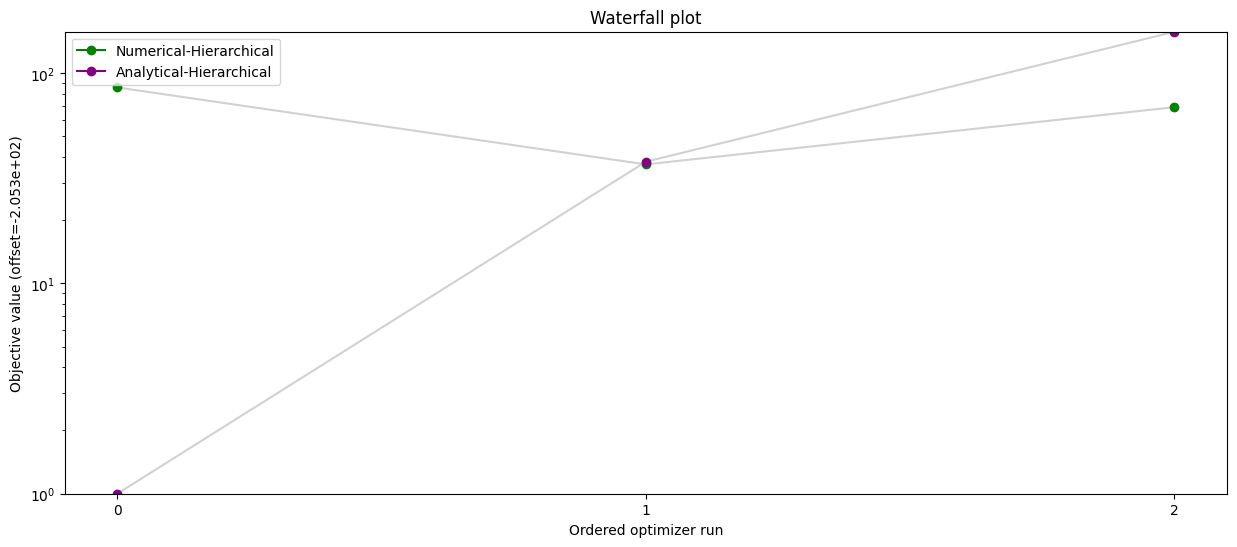

In [8]:
# Waterfall plot - analytical vs numerical inner solver
pypesto.visualize.waterfall(
    [result_num, result_ana],
    legends=['Numerical-Hierarchical', 'Analytical-Hierarchical'],
    size=(15, 6),
    order_by_id=True,
    colors=np.array(list(map(to_rgba, ('green', 'purple')))),
)
plt.savefig("num_ana.png")

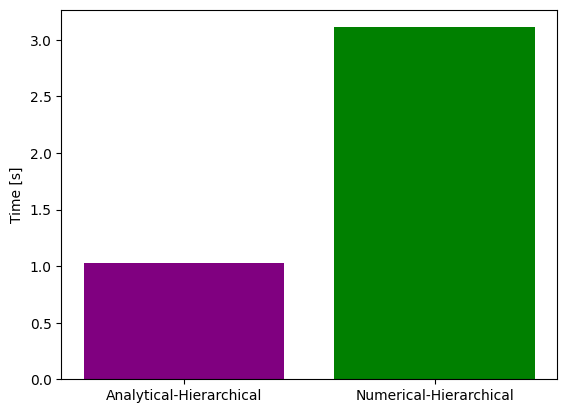

In [9]:
# Time comparison - analytical vs numerical inner solver
ax = plt.bar(x=[0, 1], height=[time_ana, time_num], color=['purple', 'green'])
ax = plt.gca()
ax.set_xticks([0, 1])
ax.set_xticklabels(['Analytical-Hierarchical', 'Numerical-Hierarchical'])
ax.set_ylabel('Time [s]')
plt.savefig("num_ana_time.png")

## Comparison of hierarchical and non-hierarchical optimization

In [10]:
# Run standard optimization
start_time = time.time()
result_ord = pypesto.optimize.minimize(problem2, **minimize_kwargs)
print(f"{result_ord.optimize_result.get_for_key('fval')=}")
time_ord = time.time() - start_time
print(f"{time_ord=}")

Performing parallel task execution on 3 processes.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2714.17it/s]2022-11-14 22:25:10 fides(WARNING) Stopping as function difference 1.67E-06 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
2022-11-14 22:25:10 fides(WARNING) Stopping as function difference 2.87E-06 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
2022-11-14 22:25:10 fides(WARNING) Stopping as function difference 2.69E-07 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)


result_ord.optimize_result.get_for_key('fval')=[541.2499015343064, 542.509125891861, 573.7525444117754]
time_ord=0.18532967567443848


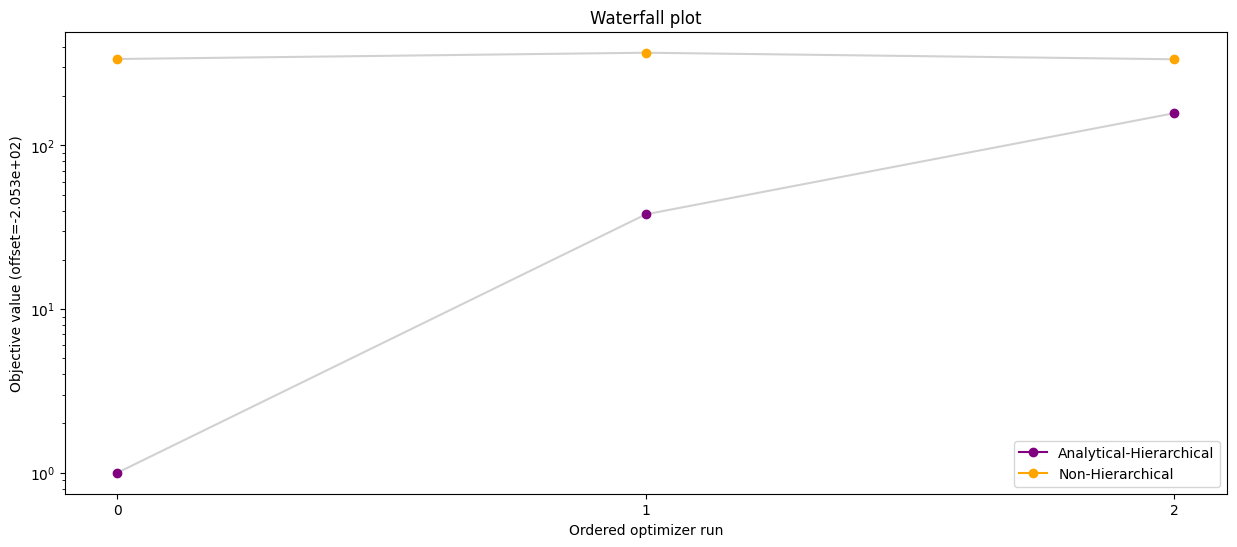

In [11]:
# Waterfall plot - hierarchical optimization with analytical inner solver vs standard optimization
pypesto.visualize.waterfall(
    [result_ana, result_ord],
    legends=['Analytical-Hierarchical', 'Non-Hierarchical'],
    order_by_id=True,
    colors=np.array(list(map(to_rgba, ('purple', 'orange')))),
    size=(15, 6),
)
plt.savefig("ana_ord.png")

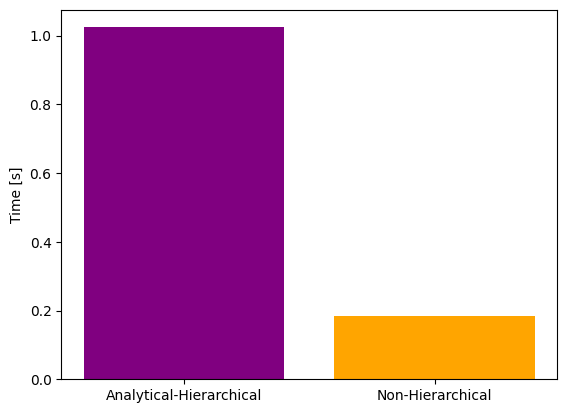

In [12]:
# Time comparison - hierarchical optimization with analytical inner solver vs standard optimization
import matplotlib.pyplot as plt

ax = plt.bar(x=[0, 1], height=[time_ana, time_ord], color=['purple', 'orange'])
ax = plt.gca()
ax.set_xticks([0, 1])
ax.set_xticklabels(['Analytical-Hierarchical', 'Non-Hierarchical'])
ax.set_ylabel('Time [s]')
plt.savefig("ana_ord_time.png")

## Comparison of hierarchical and non-hierarchical optimization with adjoint and forward sensitivities

In [13]:
# Run hierarchical optimization with analytical inner solver and forward sensitivities
start_time = time.time()
problem.objective.calculator.inner_solver = AnalyticalInnerSolver()
problem.objective.amici_solver.setSensitivityMethod(
    amici.SensitivityMethod_forward
)
result_ana_fw = pypesto.optimize.minimize(problem, **minimize_kwargs)
print(f"{result_ana_fw.optimize_result.get_for_key('fval')=}")
time_ana_fw = time.time() - start_time
print(f"{time_ana_fw=}")

Performing parallel task execution on 3 processes.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2434.77it/s]2022-11-14 22:25:11 fides(WARNING) Stopping as gradient norm satisfies absolute convergence criteria: 8.66E-07 < 1.00E-06

2022-11-14 22:25:11 fides(WARNING) Stopping as function difference 6.69E-07 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
2022-11-14 22:25:12 fides(WARNING) Stopping as function difference 3.07E-08 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)


result_ana_fw.optimize_result.get_for_key('fval')=[206.323747096273, 243.2347352730781, 362.6599421708214]
time_ana_fw=0.5685045719146729


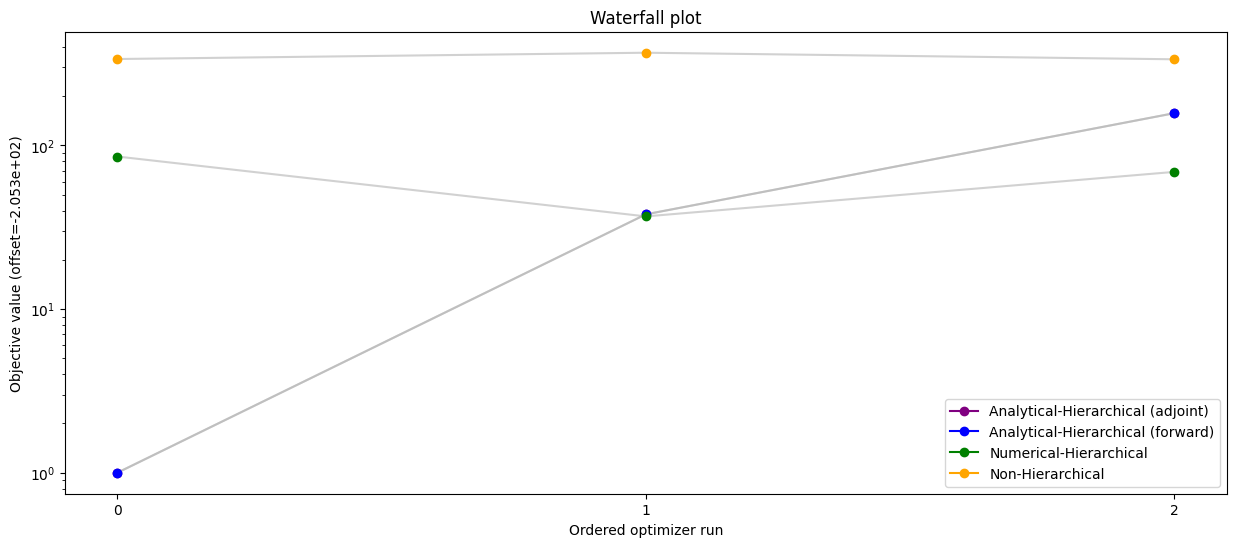

In [14]:
# Waterfall plot - compare all scenarios
pypesto.visualize.waterfall(
    [result_ana, result_ana_fw, result_num, result_ord],
    legends=[
        'Analytical-Hierarchical (adjoint)',
        'Analytical-Hierarchical (forward)',
        'Numerical-Hierarchical',
        'Non-Hierarchical',
    ],
    colors=np.array(list(map(to_rgba, ('purple', 'blue', 'green', 'orange')))),
    order_by_id=True,
    size=(15, 6),
)
plt.savefig("all.png")

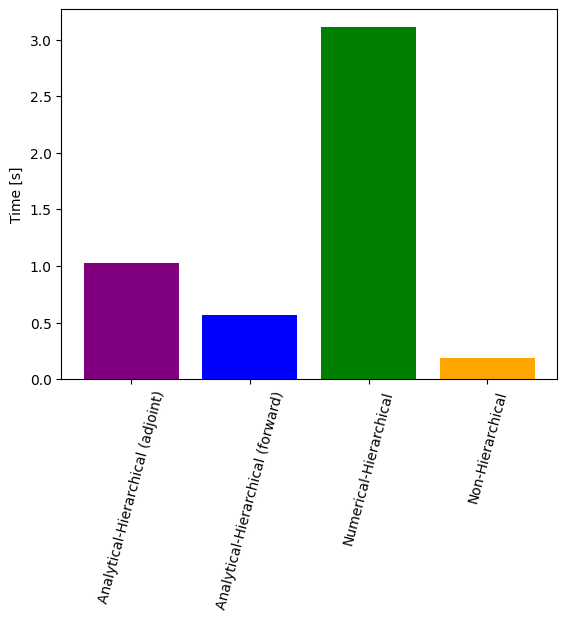

In [15]:
# Time comparison of all scenarios
import matplotlib.pyplot as plt

ax = plt.bar(
    x=[0, 1, 2, 3],
    height=[time_ana, time_ana_fw, time_num, time_ord],
    color=['purple', 'blue', 'green', 'orange'],
)
ax = plt.gca()
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(
    [
        'Analytical-Hierarchical (adjoint)',
        'Analytical-Hierarchical (forward)',
        'Numerical-Hierarchical',
        'Non-Hierarchical',
    ]
)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation=75)
ax.set_ylabel('Time [s]')
plt.savefig("all_time.png")